In [6]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle
from time import sleep


In [7]:
class Agent(object):
    
    class State(object):
        def __init__(self):
            self.count = {'state': 0, 'hit': 0, 'stick': 0}
            self.action_value = {'hit':0, 'stick':0} # action_value 추가
    
    def __init__(self):       
        self.state_dict = {} # initialization 초기화
        #self.number_of_learning = number_of_learning
        
        for dealer_card in range(1, 11):
            for player_total in range(1, 22):
                self.state_dict[(dealer_card, player_total)] = self.State()
                

In [8]:
class Agent_approx(object):
    def __init__(self):
        self.weight = np.zeros(36) 

In [30]:
def step(state, action):
    
    """
    Args:
        state (tuple) : represent dealer_card and player_total in form of tuple (dealer_card, player_total)
                       state - dealer's first card 1-10 and the player's sum 1-21
        action (str) : 'hit' or 'stick'
    
    returns:
        state (tuple) : next state determined by input action. It could be terminal
        reward (int) : player's win +1, tie 0, lose -1
    """
    
    
    if action == 'hit':
        card = _draw_card()
        
        # update player's total 
        if card[1] == 'BLACK':
            next_state = (state[0], state[1] + card[0])
        elif card[1] == 'RED':
            next_state = (state[0], state[1] - card[0])
        
        # calculate reward
        if next_state[1] > 21 or next_state[1] < 1:
            reward = -1
        else:
            reward = 0
            
    elif action == 'stick':
        # dealer's play
        print('stick! dealer\'s play')
        while True:
            card = _draw_card()
            print('dealer\'s card', card[0], card[1])
            if card[1] == 'BLACK':
                next_state = (state[0] + card[0], state[1])
            elif card[1] == 'RED':
                next_state = (state[0] - card[0], state[1])
            
            if next_state[0] >= 17 or next_state[0] < 1:
                break
            else:
                continue

        # calculate reward 
        if next_state[0] > 21 or next_state[0] < 1:
            reward = 1
        elif next_state[0] < next_state[1]:
            reward = 1
        elif next_state[0] > next_state[1]:
            reward = -1
        elif next_state[0] == next_state[0]:
            reward = 0

    return next_state, reward

In [10]:
def _draw_card():
    rand_number = random.randrange(1,11)
    color_number = np.random.random()
    
    if color_number < float(1.0/3.0):
        color = 'RED'
    else:
        color = 'BLACK'
    
    return (rand_number, color)

In [11]:
def epsilon_greedy_policy(Agent, state):
    # N_0 is constant. Feel free to choose an alternative value for N0, if it helps producing better results.
    N_0 = 100
    #N_0 = 10
    
    # exploration strategy w/ N_0 / ( N_0 _ N(s_t) ) in MC and Sarsa(\lambda)
    #if epsilon == None:
    epsilon = N_0 / (N_0 + Agent.state_dict[state].count['state'])
    print('epsilon :', epsilon)
    
    random_action = np.random.random()
    print('initial random_action :', random_action)
    if random_action > epsilon:
        if Agent.state_dict[state].action_value['hit'] > Agent.state_dict[state].action_value['stick']:
            action = 'hit'
            print('random_action and action', random_action, action)
        else:
            action = 'stick'
            print('random_action and action', random_action, action)
    else:
        random_action = np.random.random()
        if random_action > 0.5:
            action = 'hit'
            print('random_action and action', random_action, action)
        else:
            action = 'stick'
            print('random_action and action', random_action, action)
        
        
    """
    if Agent.state_dict[state].action_value['hit'] > Agent.state_dict[state].action_value['stick']:
        #hit_prob = (epsilon / 2) + 1 - epsilon
        hit_prob = 1 - epsilon
        #stick_prob = 1 - hit_prob
    elif Agent.state_dict[state].action_value['hit'] < Agent.state_dict[state].action_value['stick']:
        #hit_prob = (epsilon / 2)
        hit_prob = epsilon
    elif Agent.state_dict[state].action_value['hit'] == Agent.state_dict[state].action_value['stick']:
        hit_prob = 0.5
    
    random_action = random.random()
    if random_action < hit_prob:
        action = 'hit'
    else:
        action = 'stick'
    """
    
    return action

In [12]:
def optimal_value(Agent):

    optimal_value_dict = {}

    for (i, j) in Agent.state_dict.keys():
        optimal_value_dict[(i, j)] = max(Agent.state_dict[(i, j)].action_value['hit'], Agent.state_dict[(i, j)].action_value['stick'])

    return optimal_value_dict

In [13]:
def optimal_action(Agent):
    optimal_action_dict = {}
    
    for (i, j) in Agent.state_dict.keys():
        if Agent.state_dict[(i, j)].action_value['hit'] > Agent.state_dict[(i, j)].action_value['stick']:
            optimal_action_dict[(i, j)] = 'hit'
        elif Agent.state_dict[(i, j)].action_value['hit'] < Agent.state_dict[(i, j)].action_value['stick']:
            optimal_action_dict[(i, j)] = 'stick'
            
    return optimal_action_dict

In [14]:
def MC_learning_print(Agent, number_of_learning):
    """
    Args:
        Agent (object) : an agent which we want to make learn
        number_of_learning (int) : number_of_learning
    
    returns(void)

    """  
    for num in range(0, number_of_learning):
        visit_list = []
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_policy(Agent, initial_state)
        print('Start!')
        print('initial_state and initial_action : ', initial_state, initial_action)
        cur_state = initial_state
        cur_action = initial_action
        
        visit_list.append((cur_state, cur_action))
        print('visit_list : ', visit_list)
        #Agent.state_dict[cur_state].count['state'] += 1
        #Agent.state_dict[cur_state].count[cur_action] += 1

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            print('next_state and reward :', next_state, reward)
            if cur_action == 'stick' or reward == -1 : # terminal state
                #visit_list.append((cur_state, cur_action))
                print('End!')
                print('Terminal action : ', cur_action, 'reward : ', reward)
                break
            else:
                print('continue')
                cur_state = next_state
                cur_action = epsilon_greedy_policy(Agent, next_state)
                visit_list.append((cur_state, cur_action))
                print('cur_state and cur_action : ', cur_state, cur_action)
                print('visit_list : ', visit_list)
                #Agent.state_dict[cur_state].count['state'] += 1
                #Agent.state_dict[cur_state].count[cur_action] += 1
                continue
        
        # N and Q value update
        """Monte-Carlo Control
        N(S_t, A_t) = N(S_t, A_t) + 1 # 위에서 처리
        Q(S_t, A_t) = Q(S_t, A_t) + 1/N(S_t, A_t) * (G_t - Q(S_t, A_t) )
        
        return
        G_t = R_{t+1} + R_{t+2} + ... + R_T (discount factor = 1)
        """
        for state, action in visit_list:
            Agent.state_dict[state].count['state'] += 1
            Agent.state_dict[state].count[action] += 1
            alpha_t = 1 / Agent.state_dict[state].count[action] # step-size alpha
            Agent.state_dict[state].action_value[action] = Agent.state_dict[state].action_value[action] + alpha_t * ( reward - Agent.state_dict[state].action_value[action] )
            print('updated state and action : ', state, action)
            print('updated count and value  : ',Agent.state_dict[state].count['state'] , Agent.state_dict[state].count[action], Agent.state_dict[state].action_value[action])
        
        
        

In [15]:
def MC_learning(Agent, number_of_learning):
    """
    Args:
        Agent (object) : an agent which we want to make learn
        number_of_learning (int) : number_of_learning
    
    returns(void)

    """  
    for num in range(0, number_of_learning):
        visit_list = []
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_policy(Agent, initial_state)
        cur_state = initial_state
        cur_action = initial_action
        
        visit_list.append((cur_state, cur_action))
        #Agent.state_dict[cur_state].count['state'] += 1
        #Agent.state_dict[cur_state].count[cur_action] += 1

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            if cur_action == 'stick' or reward == -1 : # terminal state
                #visit_list.append((cur_state, cur_action))
                break
            else:
                cur_state = next_state
                cur_action = epsilon_greedy_policy(Agent, next_state)
                visit_list.append((cur_state, cur_action))
                #Agent.state_dict[cur_state].count['state'] += 1
                #Agent.state_dict[cur_state].count[cur_action] += 1
                continue
        
        # N and Q value update
        """Monte-Carlo Control
        N(S_t, A_t) = N(S_t, A_t) + 1 # 위에서 처리
        Q(S_t, A_t) = Q(S_t, A_t) + 1/N(S_t, A_t) * (G_t - Q(S_t, A_t) )
        
        return
        G_t = R_{t+1} + R_{t+2} + ... + R_T (discount factor = 1)
        """
        for state, action in visit_list:
            Agent.state_dict[state].count['state'] += 1
            Agent.state_dict[state].count[action] += 1
            alpha_t = 1 / Agent.state_dict[state].count[action] # step-size alpha
            Agent.state_dict[state].action_value[action] = Agent.state_dict[state].action_value[action] + alpha_t * ( reward - Agent.state_dict[state].action_value[action] )
        

In [16]:
def TD_learning(Agent, number_of_learning, lambda_parameter):
    """
    Args:
        Agent (object) : an agent which we want to make learn
        number_of_learning (int) : number_of_learning
        lambda_parameter (0~1) : parameter values in np.arange(0, 1.1, 0.1)
    
    returns (void)
    """
    
    for num in range(0, number_of_learning):
        step_number = 0
        sum_of_n_step_q_value = 0.0
        terminal_reward = 0.0
        
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_policy(Agent, initial_state)
        cur_state = initial_state
        cur_action = initial_action
        Agent.state_dict[cur_state].count['state'] += 1
        Agent.state_dict[cur_state].count[cur_action] += 1

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            step_number += 1 
            if cur_action == 'stick' or reward == -1 : # terminal state
                terminal_reward = lambda_parameter ** ( step_number - 1 ) * reward
                break
            else:
                cur_state = next_state
                cur_action = epsilon_greedy_policy(Agent, next_state)
                Agent.state_dict[cur_state].count['state'] += 1
                Agent.state_dict[cur_state].count[cur_action] += 1
                sum_of_n_step_q_value += lambda_parameter ** ( step_number - 1 ) * Agent.state_dict[cur_state].action_value[cur_action]
                continue

        # Q value update
        """ Sarsa(\lambda) control
        N(S_t, A_t) = N(S_t, A_t) + 1 # 위에서 처리
        Q(S_t, A_t) = Q(S_t, A_t) + 1/N(S_t, A_t) * (G_t - Q(S_t, A_t) )
        
        n-step q return ( \gamma = 1, no discount )
        q_t^(n) = R_{t+1} + R_{t+2} + ... + R_{t+n} + Q_{t+n} ( S_{t+n}, A_{t+n} ) 
        q_t^(T) = R_{t+1} + ... + R_{t+T-1} + R_{t+T} (Terminal)
        
        q^{lambda} return
        q_t^{lambda} = ( 1 - lambda_parameter ) \Sum_{n=1}^T (lambda_parameter)^{n-1} * q_t^(n)  
        """
        
        alpha_t = 1 / Agent.state_dict[initial_state].count[initial_action] # step-size alpha
        q_lambda = ( 1 - lambda_parameter ) * (sum_of_n_step_q_value) + terminal_reward
        Agent.state_dict[initial_state].action_value[initial_action] = Agent.state_dict[initial_state].action_value[initial_action] + alpha_t * ( q_lambda - Agent.state_dict[initial_state].action_value[initial_action] )
        
    
    
    
    

In [17]:
def mean_squared_error(Agent1, Agent2):
    
    #number = 0
    total = 0.0
    
    for i in range(1, 11):
        for j in range(1, 22):
            for action in Agent1.state_dict[(1, 1)].action_value.keys():
                #number += 1
                total += (Agent1.state_dict[(i, j)].action_value[action] - Agent2.state_dict[(i, j)].action_value[action]) ** 2
    
    MSE = total 
    
    return MSE

In [18]:
def make_feature_vector(state, action):
    
    feature_vector = np.zeros(36)
    
    if action == 'hit':
        action_feature = 0
    elif action == 'stick':
        action_feature = 1
        
    player_feature = state[1]
    dealer_feature = state[0]
    
    for i in range(0, 2):
        if i == action_feature:
            ii = i
        else:
            continue
        for j in range(0, 3):
            if dealer_feature in range(1 + j*3, 1 + j*3 + 4):
                jj = j
            else:
                continue
            for k in range(1, 7):
                if player_feature in range(1 + (k-1)*3, 1 + (k-1)*3 + 6 ):
                    kk = k
                else:
                    continue
                #print(action_feature, dealer_feature, player_feature, i, j, k, 18*i + 6*j + k)
                feature_vector += np.identity(36)[18*i + 6*j + k - 1]
                
    return feature_vector

In [19]:
def epsilon_greedy_approx(Agent_approx, state, epsilon):
    cur_feature_vector_hit = make_feature_vector(state, 'hit')
    cur_feature_vector_stick = make_feature_vector(state, 'stick')
    
    if sum(cur_feature_vector_hit * Agent_approx.weight) > sum(cur_feature_vector_stick * Agent_approx.weight):
        hit_prob = (epsilon / 2) + 1 - epsilon
        #hit_prob = 1 - epsilon
        #stick_prob = 1 - hit_prob
    else:
        hit_prob = (epsilon / 2)
        #hit_prob = epsilon
    
    
    random_action = random.random()
    if random_action < hit_prob:
        action = 'hit'
    else:
        action = 'stick'
    
    return action
    

In [20]:
def linear_function_approximation(Agent_approx, number_of_learning, lambda_parameter):
    """
    Arg:
        Agent_approx (object): an agent which we want to make learn using linear function approximation
        number_of_learning (int) : number_of_learning
    
    """
    
    for num in range(0, number_of_learning):
        step_number = 0
        sum_of_n_step_G_value = 0.0
        terminal_reward = 0.0
        
        initial_state = (random.randrange(1,11), random.randrange(1,22))
        initial_action = epsilon_greedy_approx(Agent_approx, initial_state, epsilon=0.05)
        initial_feature_vector = make_feature_vector(initial_state, initial_action)
        cur_state = initial_state
        cur_action = initial_action

        # terminal state까지 반복
        while True:  
            (next_state, reward) = step(cur_state, cur_action)
            step_number += 1 
            if cur_action == 'stick' or reward == -1 : # terminal state
                terminal_reward = lambda_parameter ** ( step_number - 1 ) * reward
                break
            else:
                cur_state = next_state
                cur_action = epsilon_greedy_approx(Agent_approx, next_state, epsilon=0.05)
                cur_feature_vector = make_feature_vector(cur_state, cur_action)
                sum_of_n_step_G_value += lambda_parameter ** ( step_number - 1 ) * sum( cur_feature_vector * Agent_approx.weight )
                continue

        # Q value update
        """ Sarsa(\lambda) Value Function Approximation
        Δw = α (G_t^{lambda} - v(S_t, w)) x(S_t)
        
        n-step G return ( \gamma = 1, no discount )
        G_t^(n) = R_{t+1} + R_{t+2} + ... + R_{t+n} + V_{t+n} ( S_{t+n}, w ) 
        G_t^(T) = R_{t+1} + ... + R_{t+T-1} + R_{t+T} (Terminal)
        
        G^{lambda} return
        G_t^{lambda} = ( 1 - lambda_parameter ) \Sum_{n=1}^T (lambda_parameter)^{n-1} * G_t^(n)  
        """
        
        alpha = 0.01 # step-size alpha (constant)
        G_lambda = ( 1 - lambda_parameter ) * (sum_of_n_step_G_value) + terminal_reward
        Agent_approx.weight = Agent_approx.weight + alpha * ( G_lambda - sum( initial_feature_vector * Agent_approx.weight ) ) * initial_feature_vector


In [21]:
def mean_squared_error_approx(Agent, Agent_approx):
    #number = 0
    total = 0.0
    
    for i in range(1, 11):
        for j in range(1, 22):
            for action in Agent.state_dict[(1, 1)].action_value.keys():
                feature_vector = make_feature_vector((i, j), action)
                #number += 1
                total += (Agent.state_dict[(i, j)].action_value[action] - sum(Agent_approx.weight * feature_vector) ) ** 2
    
    MSE = total
    
    return MSE

In [22]:
def plot_optimal_value(optimal_value_dict):
    x = np.arange(1,11,1)
    y = np.arange(1,22,1)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros((21, 10))
    for i in range(0, 21):
        for j in range(0, 10):
            Z[i][j] = optimal_value_dict[(j+1,i+1)]

    fig = plt.figure(figsize=(15,5))
    fig.clf()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    
    plt.xlim([1,10])
    plt.xlabel('dealer showing', fontsize=18)
    plt.ylim([1,21])
    plt.ylabel('player sum', fontsize=18)
    fig.suptitle('Monte Carlo Control', fontsize=20)
    ax.set_xticks(range(1,11))
    ax.set_yticks(range(1,22))

    fig.savefig('mcc.png')


    plt.draw()
    plt.show(block=False)
    plt.pause(0.1)
        
    plt.show()

In [23]:
def plot_MSE(optimal_agent):
    x = np.arange(0, 1.1, 0.1)
    y = np.zeros(11)

    for i in range(0, 11):
        TD_agent_lambda = Agent()
        TD_learning(TD_agent_lambda, 1000, i*0.1)
        y[i] = mean_squared_error(optimal_agent, TD_agent_lambda)
    
    fig = plt.figure()
    plt.xlabel('lambda λ')
    plt.ylabel('MSE')
    plt.title('mean-squared error against λ')
    plt.plot(x, y)
    plt.show()
        
        

In [24]:
def plot_MSE_approx(optimal_agent):
    x = np.arange(0, 1.1, 0.1)
    y = np.zeros(11)
    for i in range(0, 11):
        approx_agent_lambda = Agent_approx()
        linear_function_approximation(approx_agent_lambda, 1000, i*0.1)
        y[i] = mean_squared_error_approx(optimal_agent, approx_agent_lambda)
    
    fig = plt.figure()
    plt.xlabel('lambda λ')
    plt.ylabel('MSE')
    plt.title('mean-squared error against λ (linear function approximation)')
    plt.plot(x, y)
    plt.show()

In [25]:
def plot_learning_curve(optimal_agent, scale_of_learning):
    x = np.arange(0, 11*scale_of_learning, scale_of_learning)
    y_0 = np.zeros(11)
    y_1 = np.zeros(11)
    
    for i in range(0, 11):
        TD_agent_lambda_0 = Agent()
        TD_agent_lambda_1 = Agent()
        TD_learning(TD_agent_lambda_0, scale_of_learning*(i), 0)
        TD_learning(TD_agent_lambda_1, scale_of_learning*(i), 1)
        y_0[i] = mean_squared_error(optimal_agent, TD_agent_lambda_0)
        y_1[i] = mean_squared_error(optimal_agent, TD_agent_lambda_1)
    
    fig = plt.figure()
    plt.xlabel('number of episodes')
    plt.ylabel('MSE')
    plt.plot(x, y_0, 'b', label='λ = 0')
    plt.plot(x, y_1, 'r', label='λ = 1')
    plt.legend(loc='upper right')
    plt.title('Learning Curve of mean-squared error against episode number of Sarsa(λ)')
    plt.show()

In [26]:
def plot_learning_curve_approx(optimal_agent, scale_of_learning):
    x = np.arange(0, 11*scale_of_learning, scale_of_learning)
    y_0 = np.zeros(11)
    y_1 = np.zeros(11)
    
    for i in range(0, 11):
        approx_agent_lambda_0 = Agent_approx()
        approx_agent_lambda_1 = Agent_approx()
        linear_function_approximation(approx_agent_lambda_0, scale_of_learning*(i), 0)
        linear_function_approximation(approx_agent_lambda_1, scale_of_learning*(i), 1)
        y_0[i] = mean_squared_error_approx(optimal_agent, approx_agent_lambda_0)
        y_1[i] = mean_squared_error_approx(optimal_agent, approx_agent_lambda_1)
    
    fig = plt.figure()
    plt.xlabel('number of episodes')
    plt.ylabel('MSE')
    plt.plot(x, y_0, 'b', label='λ = 0')
    plt.plot(x, y_1, 'r', label='λ = 1')
    plt.legend(loc='upper right')
    plt.title('Learning Curve of mean-squared error against episode number of Linear Function Approximation')
    plt.show()

In [22]:
MC_agent_optimal = Agent()
MC_learning(MC_agent_optimal, 100000)
MC_optimal_value = optimal_value(MC_agent_optimal)

In [28]:
MC_test = Agent()


In [ ]:
MC_learning_print(MC_test, 100)

In [ ]:
MC_learning_print(MC_test, 100)

In [31]:
MC_learning_print(MC_test, 5)

epsilon : 1.0
initial random_action : 0.5232543830473523
random_action and action 0.6932538098775294 hit
Start!
initial_state and initial_action :  (9, 18) hit
visit_list :  [((9, 18), 'hit')]
next_state and reward : (9, 22) -1
End!
Terminal action :  hit reward :  -1
updated state and action :  (9, 18) hit
updated count and value  :  1 1 -1.0
epsilon : 1.0
initial random_action : 0.7699035214262738
random_action and action 0.5087795223985632 hit
Start!
initial_state and initial_action :  (4, 18) hit
visit_list :  [((4, 18), 'hit')]
next_state and reward : (4, 23) -1
End!
Terminal action :  hit reward :  -1
updated state and action :  (4, 18) hit
updated count and value  :  1 1 -1.0
epsilon : 1.0
initial random_action : 0.4412153074342605
random_action and action 0.5291445398501105 hit
Start!
initial_state and initial_action :  (4, 4) hit
visit_list :  [((4, 4), 'hit')]
next_state and reward : (4, -5) -1
End!
Terminal action :  hit reward :  -1
updated state and action :  (4, 4) hit
up

In [26]:
MC_learning_print(MC_agent_optimal, 5)

Start!
initial_state and initial_action :  (5, 8) stick
visit_list :  [((5, 8), 'stick')]
next_state and reward : (-4, 8) 1
End!
Terminal action :  stick reward :  1
updated state and action :  (5, 8) stick
updated count and value  :  542 436 1.0
Start!
initial_state and initial_action :  (6, 10) stick
visit_list :  [((6, 10), 'stick')]
next_state and reward : (-4, 10) 1
End!
Terminal action :  stick reward :  1
updated state and action :  (6, 10) stick
updated count and value  :  576 486 1.0
Start!
initial_state and initial_action :  (10, 6) hit
visit_list :  [((10, 6), 'hit')]
next_state and reward : (10, 13) 0
continue
cur_state and cur_action :  (10, 13) hit
visit_list :  [((10, 6), 'hit'), ((10, 13), 'hit')]
next_state and reward : (10, 8) 0
continue
cur_state and cur_action :  (10, 8) hit
visit_list :  [((10, 6), 'hit'), ((10, 13), 'hit'), ((10, 8), 'hit')]
next_state and reward : (10, 4) 0
continue
cur_state and cur_action :  (10, 4) hit
visit_list :  [((10, 6), 'hit'), ((10, 13

# Plotting the optimal value funtion of result of MC learning

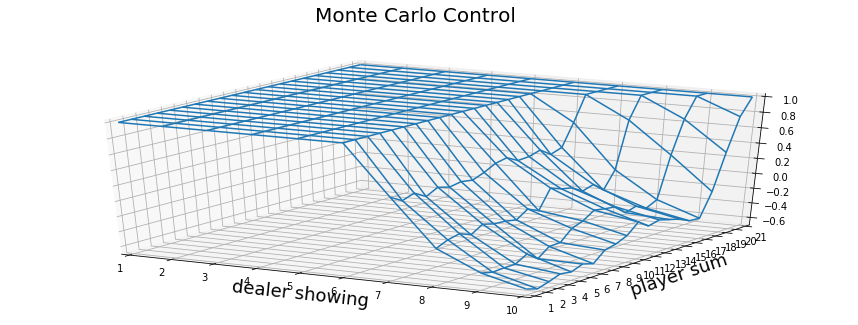

In [23]:
plot_optimal_value(MC_optimal_value)

In [ ]:
TD_test = Agent()

In [ ]:
TD_learning(TD_test, 5000, 1)
TD_optimal_value = optimal_value(TD_test)

In [ ]:
plot_optimal_value(TD_optimal_value)

# Plotting the mean-squared error against λ of Sarsa(λ) learning

In [ ]:
plot_MSE(MC_agent_optimal)

# Plotting the mean-squared error against λ of Linear Function Approximation using Sarsa(λ)

In [ ]:
plot_MSE_approx(MC_agent_optimal)

# Learning Curve of mean-squared error against episode number of Sarsa(λ)

In [ ]:
plot_learning_curve(MC_agent_optimal, 10000)

# Learning Curve of mean-squared error against episode number of Linear Function Approximation 

In [ ]:
plot_learning_curve_approx(MC_agent_optimal, 1000)

# Discussion

* What are the pros and cons of bootstrapping in Easy21?


* Would you expect bootstrapping to help more in blackjack or Easy21? Why?


* What are the pros and cons of function approximation in Easy21?


* How would you modify the function approximator suggested in this section to get better results in Easy21?
